# Creating a wildtype (WT / PD0), and Parkinson degeneration (PD2) network

In the directory ```network_path``` we have three sub directories ```PD0```, ```PD2-ref``` and ```PD2```. In order to generate the ```PD2``` network, we degenerate the ```PD0``` network by swapping the WT morphologies for the PD2 morphologies. In addition a subset of the synapses in the ```PD2-ref``` network are added to compensate for differences in pruning.

We need to specify a ```connection_override``` file. The difference compared to the standard connection file is that it contains ```recovery``` information, i.e. the fraction of synapses from the ```PD2-ref``` network that should be added to the ```PD2``` network.

The ```rc``` object is a ```ipyparallel``` ```RemoteClient``` object for parallel execution.

If you want to remap external input that was removed to a new position, then use ```remap_removed_input = True```

In [1]:
import os

network_path = os.path.join("networks","PD-example-2k")
#network_path = os.path.join("networks","PD-example-2_ref_0.9")

network_path_pd0 = os.path.join(network_path, "PD0")
network_path_pd2_ref = os.path.join(network_path, "PD2-ref")
network_path_pd2 = os.path.join(network_path, "PD2")

network_size = 2000
input_config = "test-input.json"  # Only background input will be used in this example

snudda_data_base_path = os.path.join("..", "..", "..", "..", "BasalGangliaData", "Parkinson", "20220225")
snudda_data_pd0 = os.path.join(snudda_data_base_path, "PD0")
snudda_data_pd2 = os.path.join(snudda_data_base_path, "PD2")

network_config_pd0 = os.path.join(snudda_data_base_path, "connectivity", "network-config.json")
network_config_pd2 = os.path.join(snudda_data_base_path, "connectivity", "network-config-PD-synapse-recovery.json")

input_pd0 = os.path.join(network_path_pd0, "input-spikes.hdf5")
input_pd2 = os.path.join(network_path_pd2, "input-spikes.hdf5")

# Do we want to remap removed input?
remap_removed_input = False
remapped_fraction = 0.0

# Do we want to remap removed input?
#remap_removed_input = True
#remapped_fraction = 0.9

rc = None

## First generate the WT reference network

In [ ]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd0, random_seed=123456, snudda_data=snudda_data_pd0,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd0)

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path_pd0, verbose=False, rc=rc)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path_pd0, rc=rc)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path_pd0, rc=rc)
sp.prune()

In [ ]:
import os
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path_pd0, 
                 input_config_file=input_config,
                 verbose=False)
si.generate()

## Generate a PD2 reference network

This network will not have the same synapses as the WT, but it is used in order to add "recovery synapses" to compensate for part of the degeneration.

In [ ]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path_pd2_ref, random_seed=123456, snudda_data=snudda_data_pd2,
                struct_def={"Striatum": network_size}, connection_override_file=network_config_pd2)

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path_pd2_ref, verbose=False, rc=rc)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path_pd2_ref, rc=rc)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path_pd2_ref, rc=rc)
sp.prune()

In [ ]:
import os
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path_pd2_ref, rc=rc, 
                 input_config_file=input_config,
                 verbose=False)
si.generate()

## Degenerating the PD0 network to get PD2 network

In [ ]:
network_file_pd0 = os.path.join(network_path_pd0, "network-synapses.hdf5")
network_file_pd2_ref = os.path.join(network_path_pd2_ref, "network-synapses.hdf5")
network_file_pd2 = os.path.join(network_path_pd2, "network-synapses.hdf5")

from snudda.utils.swap_to_degenerated_morphologies_extended import SwapToDegeneratedMorphologiesExtended
swap = SwapToDegeneratedMorphologiesExtended(original_network_file=network_file_pd0,
                                             updated_network_file=network_file_pd2_ref,
                                             output_network_file=network_file_pd2,
                                             original_snudda_data_dir=snudda_data_pd0,
                                             updated_snudda_data_dir=snudda_data_pd2,
                                             original_input_file=input_pd0,
                                             output_input_file=input_pd2)
swap.write_new_network_file()
swap.write_new_input_file(remap_removed_input=remap_removed_input, remapped_fraction=remapped_fraction)
swap.close()

## Plotting of a degenerated neuron

In [ ]:
# This is so we get the most central dSPN in the network
from snudda import SnuddaLoad
sl = SnuddaLoad(network_path_pd0)
neuron_id = list(sl.get_centre_neurons_iterator(neuron_type="dSPN", n_neurons=1))[0][0]

In [ ]:
# neuron_id = 55
neuron_id

In [ ]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

# Note here original and degenerate path were the same, so we are plotting the full neuron and its synapses.
pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd0)

pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)
#internal synapses are blue
#external synapses are red

In [ ]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2)

pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)

In [ ]:
%matplotlib inline
from snudda.plotting.plot_degeneration import PlotDegeneration

pd = PlotDegeneration(original_network_path=network_path_pd0,
                      degenerated_network_path=network_path_pd2_ref)
#neuron_id = 55
pd.plot_neuron(neuron_id=neuron_id, figure_size=(12,12), 
               show_internal_synapses=True, hide_axis=False)

In [ ]:
from snudda.analyse.analyse_input import AnalyseInput

pd0_input_info = AnalyseInput(input_file=input_pd0, network_path=network_path_pd0)
pd2_input_info = AnalyseInput(input_file=input_pd2, network_path=network_path_pd2)

In [ ]:
pd0_input_info.plot_input_count("PD0-input_example.png")
pd2_input_info.plot_input_count("PD2-input_example.png")

In [ ]:
cmd_str1 = f"snudda_load {network_path_pd0}/network-synapses.hdf5 --countSyn"
cmd_str2 = f"snudda_load {network_path_pd2}/network-synapses.hdf5 --countSyn"
cmd_str3 = f"snudda_load {network_path_pd2_ref}/network-synapses.hdf5 --countSyn"

print("WT")
os.system(cmd_str1)
print("\nPD2")
os.system(cmd_str2)
print("\nPD2 degenerated")
os.system(cmd_str3)

In [ ]:
cmd_str1 = f"snudda_load {network_path_pd0}/network-synapses.hdf5 --listPre {neuron_id}"
cmd_str2 = f"snudda_load {network_path_pd2}/network-synapses.hdf5 --listPre {neuron_id}"
cmd_str3 = f"snudda_load {network_path_pd2_ref}/network-synapses.hdf5 --listPre {neuron_id}"

print("WT")
os.system(cmd_str1)
print("\nPD2")
os.system(cmd_str2)
print("\nPD2 degenerated")
os.system(cmd_str3)

In [ ]:
from snudda.plotting.plot_degeneration_and_growth import PlotDegenerationAndGrowth
pdg = PlotDegenerationAndGrowth(original_network_path=network_path_pd0, 
                                degenerated_network_path=network_path_pd2, 
                                neuron_id=neuron_id)
pdg.plot_synapses()

In [ ]:
from snudda.plotting.plot_degeneration_and_growth import PlotDegenerationAndGrowth
pdg = PlotDegenerationAndGrowth(original_network_path=network_path_pd0, 
                                degenerated_network_path=network_path_pd2_ref, 
                                neuron_id=neuron_id)
pdg.plot_synapses()

In [2]:
from snudda.analyse.analyse import SnuddaAnalyse


network_file_pd0 = os.path.join(network_path_pd0, "network-synapses.hdf5")
network_file_pd2 = os.path.join(network_path_pd2, "network-synapses.hdf5")
network_file_pd2_ref = os.path.join(network_path_pd2_ref, "network-synapses.hdf5")

dist3D = False
y_max_H = None

sa_pd0 = SnuddaAnalyse(network_file_pd0)
sa_pd2 = SnuddaAnalyse(network_file_pd2)
sa_pd2_ref = SnuddaAnalyse(network_file_pd2_ref)    

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Number of neurons: 1999
Synapse row 0 - 0.0 % time: 0.05012214700036566 seconds
Created connection matrix 0.8570111629996973 seconds
GJ row : 0 - 0.0 %  time : 0.0014952480014471803 seconds
Created gap junction connection matrix 0.0019229140016250312 seconds
Creating population dictionary
Done.
Taking corner neurons: Keeping 1999/1999
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 730326, at 0
Created distance histogram (optimised) in 0.8650569489982445 seconds
Saving cache to networks/PD-example-2k/PD0/network-synapses.hdf5-cache
Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Number of neurons: 1999
Synapse row 0 - 0.0 % time: 0.037416037997900276 seconds
Created connection matrix 0.3776520419996814 seconds
GJ row : 0 - 0.0 %  time : 0.0007553739997092634 seconds
Created gap junction connection matrix 0.0011672900000121444 se

Plotting connection probability dSPN to iSPN (synapses)
Centering in None : Keeping 968/968
Counting connections


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1406: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


Requested: 10000000.0 calculated [937024.]
P(d<5e-05) = 0.05700282752120641
P(d<0.0001) = 0.04346087598425197
Plotting connection probability dSPN to iSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [937024.]


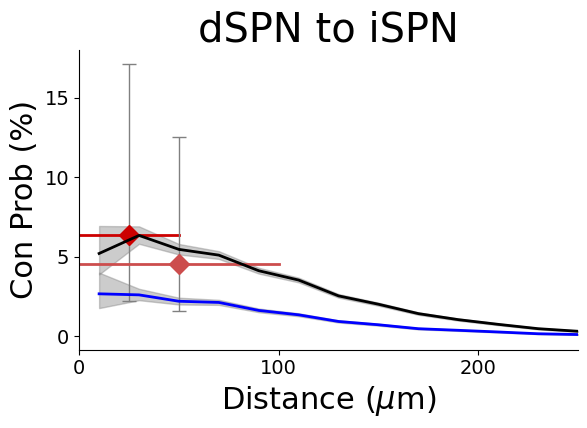

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-dSPN-to-iSPN-synapses-3D-dist.png


({},
 'networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-dSPN-to-iSPN-synapses-3D-dist.png')

In [3]:
ax = sa_pd0.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("dSPN", "iSPN", dist_3d=True, ax=ax, colour="blue")

Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 14336 connections


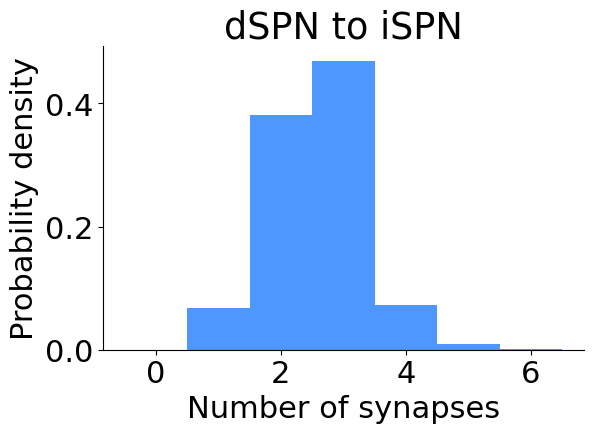

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-dSPN-to-iSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 5323 connections


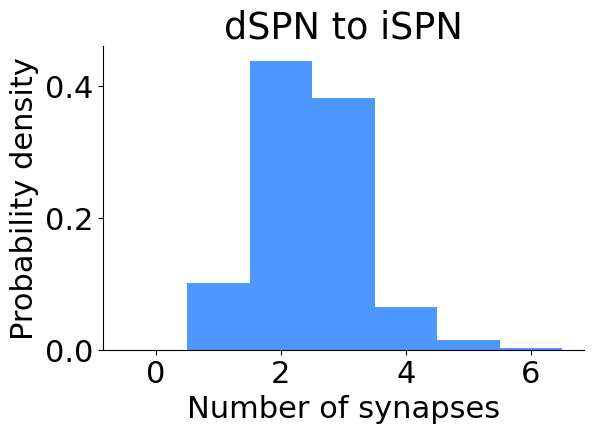

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-dSPN-to-iSPN-per-cell.png


In [4]:
sa_pd0.plot_num_synapses_per_pair("dSPN", "iSPN")
sa_pd2.plot_num_synapses_per_pair("dSPN", "iSPN")

Plotting connection probability dSPN to dSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [936056.]
P(d<5e-05) = 0.24238578680203046
P(d<0.0001) = 0.16455704041317298
Plotting connection probability dSPN to dSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [936056.]


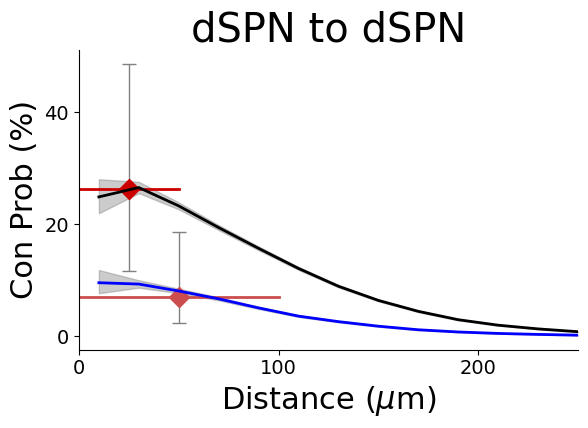

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-dSPN-to-dSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 48775 connections


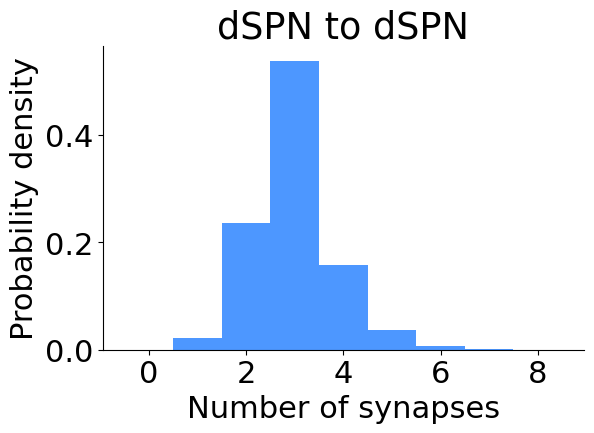

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-dSPN-to-dSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 14549 connections


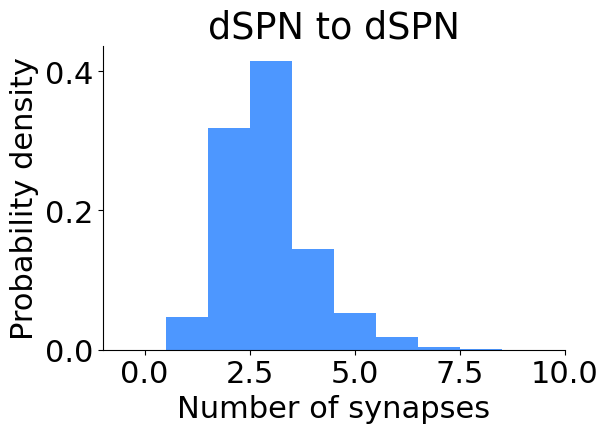

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-dSPN-to-dSPN-per-cell.png


In [5]:
sa_pd0.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("dSPN", "dSPN", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("dSPN", "dSPN")
sa_pd2.plot_num_synapses_per_pair("dSPN", "dSPN")


Plotting connection probability iSPN to iSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [936056.]
P(d<5e-05) = 0.349438713592233
P(d<0.0001) = 0.2699842157426554
Plotting connection probability iSPN to iSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [936056.]


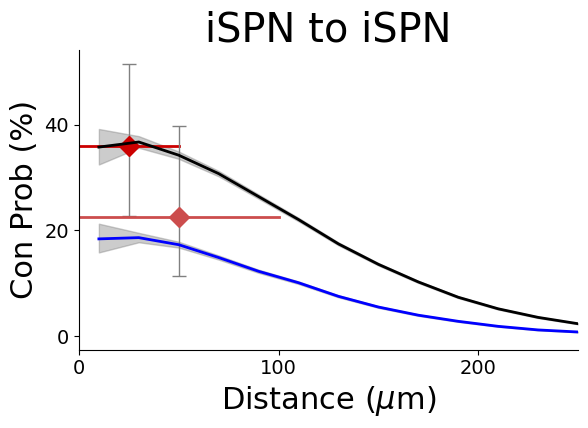

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-iSPN-to-iSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 95492 connections


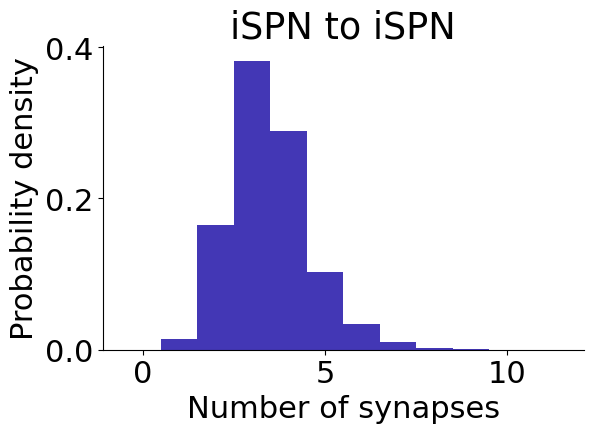

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-iSPN-to-iSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 41040 connections


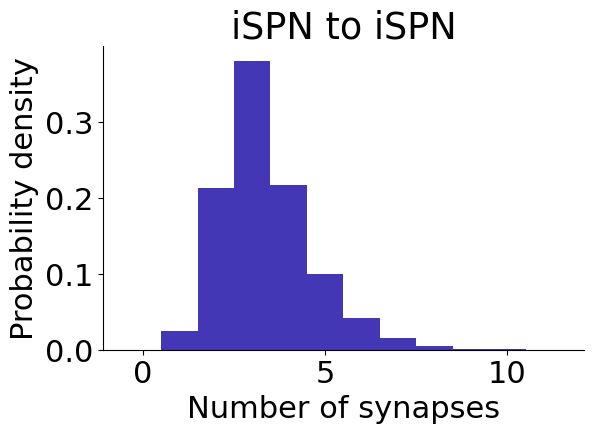

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-iSPN-to-iSPN-per-cell.png


In [6]:
sa_pd0.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("iSPN", "iSPN", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("iSPN", "iSPN")
sa_pd2.plot_num_synapses_per_pair("iSPN", "iSPN")

Plotting connection probability iSPN to dSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [937024.]
P(d<5e-05) = 0.25741753063147976
P(d<0.0001) = 0.17295767716535432
Plotting connection probability iSPN to dSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [937024.]


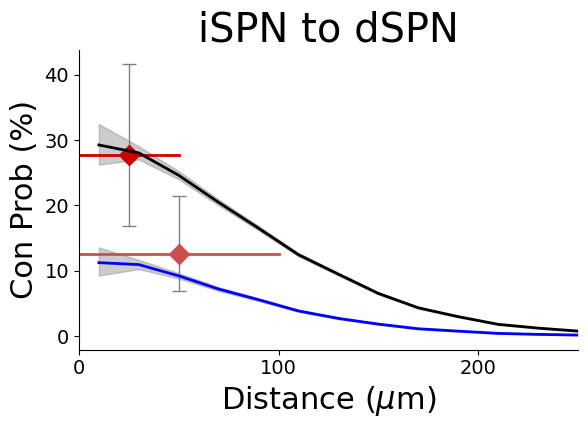

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-iSPN-to-dSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 50749 connections


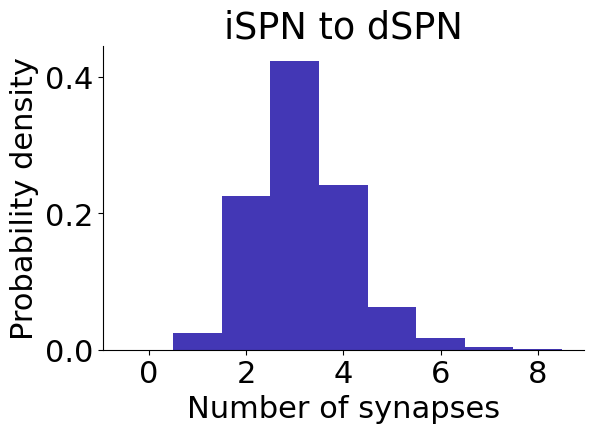

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-iSPN-to-dSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 15678 connections


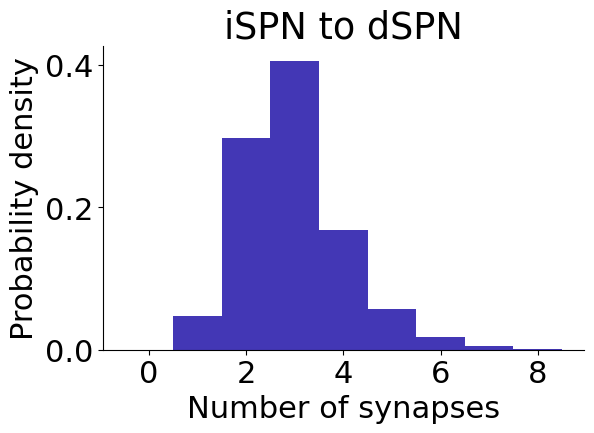

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-iSPN-to-dSPN-per-cell.png


In [7]:
sa_pd0.plot_connection_probability("iSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(13, 47), (10, 80)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("iSPN", "dSPN", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("iSPN", "dSPN")
sa_pd2.plot_num_synapses_per_pair("iSPN", "dSPN")

Plotting connection probability FS to FS (synapses)
Centering in None : Keeping 27/27
Counting connections
Requested: 10000000.0 calculated [702.]
P(d<0.00025) = 0.17753623188405798
Plotting connection probability FS to FS (synapses)
Centering in None : Keeping 27/27
Counting connections
Requested: 10000000.0 calculated [702.]


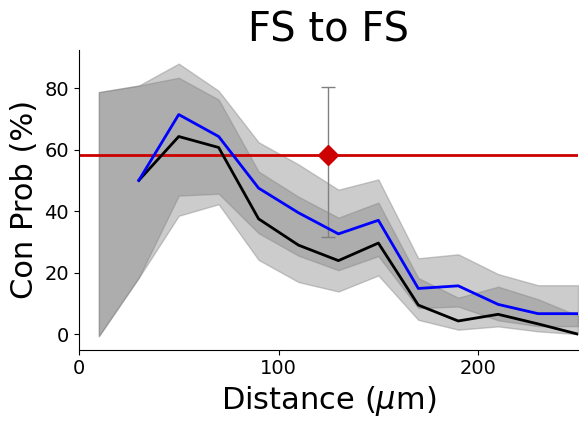

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-FS-to-FS-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 27/27
Calculating max synapses
Calculating mean synapses
Plotting 98 connections


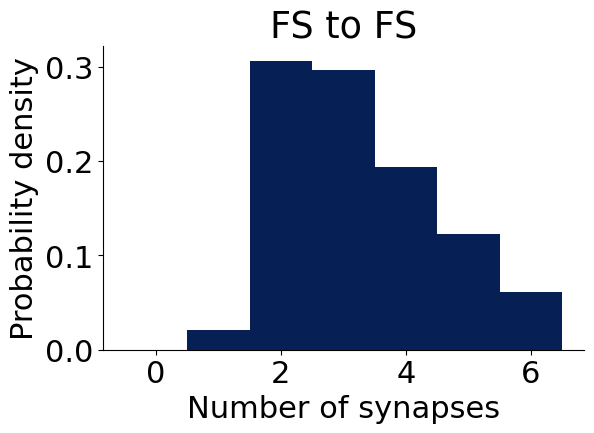

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-FS-to-FS-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 27/27
Calculating max synapses
Calculating mean synapses
Plotting 136 connections


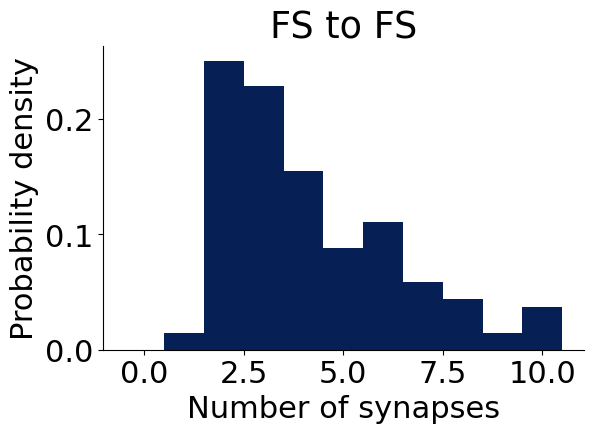

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-FS-to-FS-per-cell.png


In [8]:
sa_pd0.plot_connection_probability("FS", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(7, 12)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("FS", "FS", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("FS", "FS")
sa_pd2.plot_num_synapses_per_pair("FS", "FS")

Plotting connection probability FS to iSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [26136.]
P(d<0.0001) = 0.4712845243314336
P(d<0.00015) = 0.3580303203009233
P(d<0.00025) = 0.192097639739754
Plotting connection probability FS to iSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [26136.]


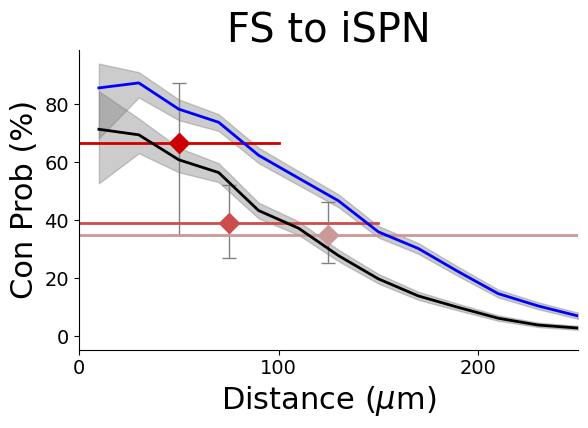

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-FS-to-iSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 4098 connections


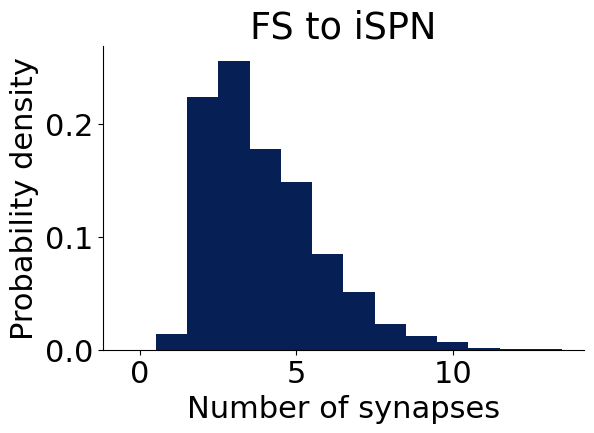

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-FS-to-iSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 6935 connections


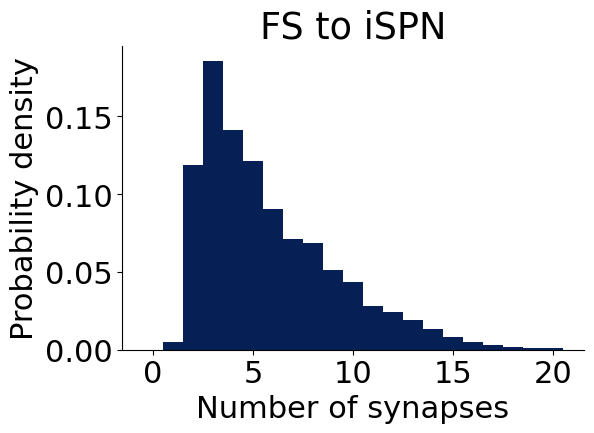

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-FS-to-iSPN-per-cell.png


In [9]:
sa_pd0.plot_connection_probability("FS", "iSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(6, 9), (21, 54), (27,77)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("FS", "iSPN", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("FS", "iSPN")
sa_pd2.plot_num_synapses_per_pair("FS", "iSPN")

Plotting connection probability FS to dSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [26136.]
P(d<0.0001) = 0.6475977653631285
P(d<0.00015) = 0.5108149187419618
P(d<0.00025) = 0.2793372781065089
Plotting connection probability FS to dSPN (synapses)
Centering in None : Keeping 968/968
Counting connections
Requested: 10000000.0 calculated [26136.]


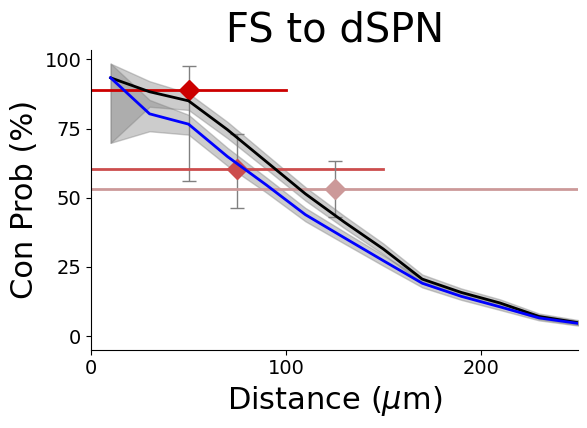

Wrote networks/PD-example-2k/PD2/figures/Network-distance-dependent-connection-probability-FS-to-dSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 6003 connections


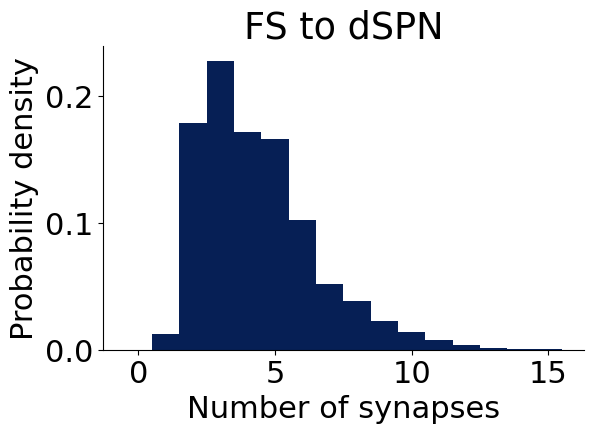

Wrote networks/PD-example-2k/PD0/figures/Network-number-of-synapses-from-FS-to-dSPN-per-cell.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 968/968
Calculating max synapses
Calculating mean synapses
Plotting 5289 connections


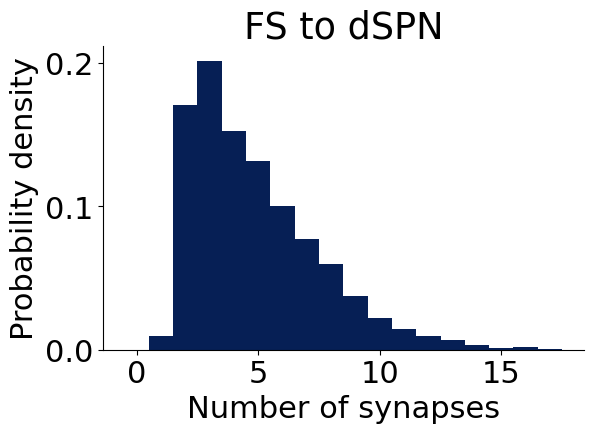

Wrote networks/PD-example-2k/PD2/figures/Network-number-of-synapses-from-FS-to-dSPN-per-cell.png


In [10]:
sa_pd0.plot_connection_probability("FS", "dSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(8, 9), (29, 48), (48,90)], return_ax=True, show_plot=False, save_figure=False)
sa_pd2.plot_connection_probability("FS", "dSPN", dist_3d=True, ax=ax, colour="blue")

sa_pd0.plot_num_synapses_per_pair("FS", "dSPN")
sa_pd2.plot_num_synapses_per_pair("FS", "dSPN")